In [1]:
from mongoengine import *
import numpy as np
import datetime 
import pandas
import matplotlib.pyplot as plt
import sklearn
import tabulate

In [2]:
connect("GDP-test", host = "localhost", port = 27017)
class Detection(Document):
    id_webcam = IntField(required=True)
    city = StringField(required=True)
    location = StringField(required=True)
    latitude = FloatField(required=True)
    longitude = FloatField(required=True)
    numPeople = IntField(required=True)
    date = DateTimeField(required=True)
    time = DateTimeField(required=True)
    type = IntField(required=True)
    weather_description = StringField()
    temperature = FloatField()
    day_of_week = IntField()

In [3]:
#print(Detection.objects.distinct('city')) # vedere se posso prendere solo le città per poi fare query distinte
table = pandas.DataFrame(Detection.objects(city='Roma').as_pymongo()) #prelevo i dati di roma

most_freq = lambda x: x.value_counts(dropna=False).index[0]

table_a = table
table_a = table_a.drop(columns = ['_id','id_webcam','city','type','date','location','latitude','longitude'])
table_a['time'] = pandas.to_datetime(table_a['time'])
table_a.sort_values(by='time', inplace=True)
print(table_a.columns)
#table_1 = table_a.resample('30T', on='time').agg({'numPeople': 'mean', 'temperature' : 'mean', 'weather_description'}).head(20)
tb = table_a.groupby([pandas.Grouper(key='time', freq='30T')], as_index=False).agg( time=('time', most_freq)
                                                                   , meanPeople=('numPeople', 'mean')
                                                                   , temp=('temperature','mean')
                                                                   , weather=('weather_description', most_freq )
                                                                   , day_of_week=('day_of_week', most_freq))


tb = tb.dropna()



# tb.plot('time','meanPeople')
#tb['hour'] = tb['time'].apply(tb['time'].hour)
# #print(type tb['time'])
print(tb.to_markdown())
#print(table_a.to_markdown())
# tb.plot('time','numPeople')

Index(['numPeople', 'time', 'weather_description', 'temperature',
       'day_of_week'],
      dtype='object')
|     | time                       |   meanPeople |     temp | weather          |   day_of_week |
|----:|:---------------------------|-------------:|---------:|:-----------------|--------------:|
|   0 | 2021-03-24 09:26:55.174000 |      7       |  7.675   | clear sky        |             2 |
|   1 | 2021-03-24 09:51:55.187000 |      9.83333 |  9.24833 | clear sky        |             2 |
|   2 | 2021-03-24 10:06:55.215000 |     10.1667  | 10.35    | clear sky        |             2 |
|   3 | 2021-03-24 10:46:55.103000 |     14.5     | 11.55    | clear sky        |             2 |
|   4 | 2021-03-24 11:26:55.088000 |     15.1667  | 12.8167  | clear sky        |             2 |
|   5 | 2021-03-24 11:41:55.091000 |     13       | 13.5667  | clear sky        |             2 |
|   6 | 2021-03-24 12:21:55.082000 |     13.5     | 14.555   | clear sky        |             2 |
|   7 |

Index(['time', 'meanPeople', 'temp', 'weather', 'day_of_week'], dtype='object')


<AxesSubplot:xlabel='time'>

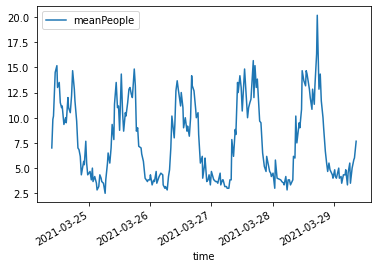

In [4]:
print(tb.columns)
tb.plot('time','meanPeople')

In [5]:
tb['time'] = tb['time'].dt.hour
#tb['time'] = (tb['time'].dt.hour).astype(int)#modifico le colonne con i valori che mi servono

In [6]:
import sklearn.model_selection

tb['weather'] = pandas.get_dummies(tb['weather']) #il weather viene convertito con parametri interi

tb = tb.reset_index()

print(tb.to_markdown())


#divide the dataframe 70-30 for train and test
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    tb[['time','temp','day_of_week','weather']], 
    tb['meanPeople'], 
    test_size = 0.33, shuffle = True, random_state= 42)

|     |   index |   time |   meanPeople |     temp |   weather |   day_of_week |
|----:|--------:|-------:|-------------:|---------:|----------:|--------------:|
|   0 |       0 |      9 |      7       |  7.675   |         0 |             2 |
|   1 |       1 |      9 |      9.83333 |  9.24833 |         0 |             2 |
|   2 |       2 |     10 |     10.1667  | 10.35    |         0 |             2 |
|   3 |       3 |     10 |     14.5     | 11.55    |         0 |             2 |
|   4 |       4 |     11 |     15.1667  | 12.8167  |         0 |             2 |
|   5 |       5 |     11 |     13       | 13.5667  |         0 |             2 |
|   6 |       6 |     12 |     13.5     | 14.555   |         0 |             2 |
|   7 |       7 |     12 |     11.5     | 14.96    |         0 |             2 |
|   8 |       8 |     13 |     11       | 15.635   |         0 |             2 |
|   9 |       9 |     13 |     11.1667  | 15.66    |         0 |             2 |
|  10 |      10 |     14 |  

<bound method NDFrame.head of      time       temp  day_of_week  weather
96      9  12.341667          4.0        0
65     17  14.868333          3.0        0
175     0  10.615000          6.0        0
201    14  18.912000          6.0        0
140     7   9.166667          5.0        0
..    ...        ...          ...      ...
106    14  17.288333          4.0        0
14     16  15.550000          2.0        0
92      7   7.431667          4.0        0
179     3   9.450000          6.0        0
102    12  17.126667          4.0        0

[159 rows x 4 columns]> 96      8.000000
65     14.833333
175     3.000000
201    12.000000
140     3.833333
         ...    
106     8.666667
14     11.000000
92      4.166667
179     3.666667
102    12.500000
Name: meanPeople, Length: 159, dtype: float64
Coefficients: 
 [-0.03073685  0.9083143  -0.43475279  0.61293141]
Residual sum of squares: 4.90
Variance score: 0.69


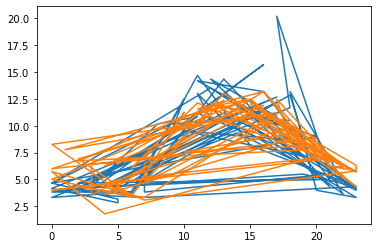

In [7]:
import sklearn.linear_model

print(x_train.head, y_train)

model = sklearn.linear_model.LinearRegression()
#provo a dargli in pasto tutto
#prima di questo ora bisogna dividere tutto il dataset in 70-30
model.fit(x_train, y_train)


# The coefficients
print('Coefficients: \n', model.coef_)

# The mean square error
print("Residual sum of squares: %.2f" % np.mean((model.predict(x_test) - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model.score(x_test, y_test))


plt.plot(x_test['time'],y_test)

plt.plot(x_test['time'],model.predict(x_test))


|    |   time |   temp |   day_of_week |   weather |
|---:|-------:|-------:|--------------:|----------:|
|  0 |      0 |      5 |             2 |         0 |
|  1 |      1 |      4 |             2 |         0 |
|  2 |      2 |      3 |             2 |         0 |
|  3 |      3 |      3 |             2 |         0 |
|  4 |      4 |      3 |             2 |         0 |
|  5 |      5 |      3 |             2 |         0 |
|  6 |      6 |      4 |             2 |         0 |
|  7 |      7 |      7 |             2 |         1 |
|  8 |      8 |      8 |             2 |         1 |
|  9 |      9 |     10 |             2 |         1 |
| 10 |     10 |     13 |             2 |         1 |
| 11 |     11 |     14 |             2 |         1 |
| 12 |     12 |     11 |             2 |         0 |
| 13 |     13 |     16 |             2 |         0 |
| 14 |     14 |     14 |             2 |         0 |
| 15 |     15 |     12 |             2 |         0 |
| 16 |     16 |     12 |             2 |      

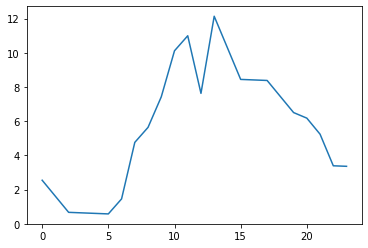

In [8]:
data = {'time':  [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
        'temp':  [5,4,3,3,3,3,4,7,8,10,13,14,11,16,14,12,12,12,11,10,9,8,6,6],
        'day_of_week': [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2],
        'weather':     [0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1]
        }

df = pandas.DataFrame (data, columns = ['time','temp','day_of_week','weather'])

print(df.to_markdown())


#print(model.predict(df))
plt.plot(df['time'],model.predict(df))

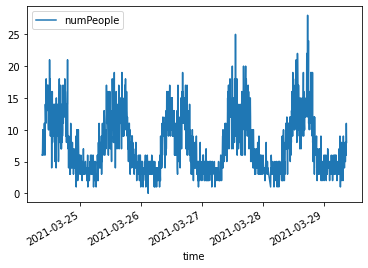

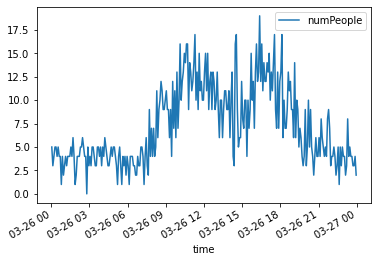

In [9]:
table = table.drop(columns = ['_id','id_webcam','city','date','type','location','latitude','longitude']) #tolgo colonne inutili
table.plot('time','numPeople')
table['time'] = table['time'].dt.strftime('%H').astype(int)#modifico le colonne con i valori che mi servono
table['weather_description'] = pandas.get_dummies(table['weather_description']) #il weather viene convertito con parametri interi
#print(table.to_markdown())

start = datetime.datetime(2021,3,26)
end = datetime.datetime(2021,3,27)
raw_query = {'date': {'$gte': start, '$lt': end}, 'city' : 'Roma'}
table = pandas.DataFrame(Detection.objects(__raw__=raw_query).as_pymongo())
table = table.drop(columns = ['_id','id_webcam','city','date','type','location','latitude','longitude'])
table.plot('time','numPeople')

#divide the dataframe 70-30 for train and test
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    table[['time','temperature','day_of_week','weather_description']], 
    table['numPeople'], 
    test_size = 0.33, shuffle = True, random_state= 42)


In [10]:
model = sklearn.linear_model.LinearRegression()
#provo a dargli in pasto tutto
#prima di questo ora bisogna dividere tutto il dataset in 70-30
model.fit(x_train, y_train)


# The coefficients
print('Coefficients: \n', model.coef_)

# The mean square error
print("Residual sum of squares: %.2f" % np.mean((model.predict(x_test) - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model.score(x_test, y_test))

plt.plot(x_test['time'],y_test)


TypeError: The DTypes <class 'numpy.dtype[float64]'> and <class 'numpy.dtype[datetime64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

In [ ]:

#robe vecchie sbagliate non guardare

time, temperature, weather, numP = table['time'].dt.strftime('%H').astype(int),table['temperature'],table['weather_description'],table['numPeople']
time = np.asarray(time)
temperature = np.asarray(temperature)
weather = np.asarray(weather)
numP = np.asarray(numP)
weatherDict = {'clear sky':0}

In [ ]:
for i in range(weather.size):
    weather[i] = weatherDict[weather[i]]

In [ ]:
temperature = temperature.reshape(-1,1)
time = time.reshape(-1,1)
weather = weather.reshape(-1,1)
timeTemp = np.concatenate((time,temperature,weather),axis = 1)
print(timeTemp)
model = sklearn.linear_model.LinearRegression()
model.fit(timeTemp,numP) 

In [ ]:
start = datetime.datetime(2021,3,24)
end = datetime.datetime(2021,3,29)
raw_query = {'date': {'$gte': start, '$lt': end}, 'city' : 'Roma'}
table = pandas.DataFrame(Detection.objects(__raw__=raw_query).as_pymongo())
table = table.drop(columns = ['_id','id_webcam','city','date','type','location','latitude','longitude'])